# Predictions on the growth of companies based on their LinkedIn data

The aim of this project is to track progressive trends of companies based on the numbers of followers and employees on the LinkedIn platform. The increase in the number of followers of a company could be considered as an indirect measure of its growth. The number of employees is a measure of the size of the company. This initial analysis answers two important questions about the companies:
1. It is possible to predict the progressive trend in a company based upon its current size and hiring rate.
2. This data can help to make a decision about the company with the maximum potential for growth in the coming years.

The dataset used for this analysis is [available at thinknum.](https://blog.thedataincubator.com/tag/data-sources/) 

For this project, I have used the data in the csv file. My future plan will be to validate this model over other aspects of a company that defines its growth, such as stock prices and the number of available jobs. I will be using web-scraping to generate this data set and plan to employ multilinear regression and decision-tree based machine learning algorithms for analysis. 

#### Import all external libraries

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.8)

import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import random

import scipy.stats as stats
import pandas_profiling
from sklearn.linear_model import LinearRegression

# Supress unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## Exploring Data

In [2]:
linkd = pd.read_csv('temp_datalab_records_linkedin_company.csv')
linkd.head()

,dataset_id,as_of_date,company_name,followers_count,employees_on_platform,link,industry,date_added,date_updated,description,website,entity_id,cusip,isin
0,58329,2015-09-14,Goldman Sachs,552254,38124,https://www.linkedin.com/company/1382,Investment Banking,2015-09-14 00:00:00+00,2015-09-14 00:00:00+00,NaN,NaN,NaN,NaN,NaN
1,58329,2015-09-15,Goldman Sachs,552862,38141,https://www.linkedin.com/company/1382,Investment Banking,2015-09-15 00:00:00+00,2015-09-15 00:00:00+00,NaN,NaN,NaN,NaN,NaN
2,58363,2015-09-16,United Technologies,59157,14982,https://www.linkedin.com/company/2426,Aviation & Aerospace,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN
3,58366,2015-09-16,Novo Nordisk,336175,26448,https://www.linkedin.com/company/2227,Pharmaceuticals,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN
4,58371,2015-09-16,"Lowe's Companies, Inc.",134255,62574,https://www.linkedin.com/company/4128,Retail,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN


In [3]:
pandas_profiling.ProfileReport(linkd)

Number of variables,14
Number of observations,2426196
Total Missing (%),32.6%
Total size in memory,259.1 MiB
Average record size in memory,112.0 B
Numeric,3
Categorical,8
Boolean,0
Date,0
Text (Unique),0
Rejected,3


## Analyzing unique companies based on their size
While an accurate measure of size can be obtained from number of job postings and number of jobs filled, which is a future step; here I have used number of employees on LinkedIn as a proxy for size of companies. 

 Recognize duplicate entries in the company names and keep the latest. This also implies keeping the entry where the company has maximum number of followers.

In [4]:
duplicate = len(linkd['company_name'])-len(linkd['company_name'].drop_duplicates())
print('Number of duplicate companies =', duplicate)
unique = linkd.company_name.nunique()
print('Number of unique apps =', unique) 
linkd['as_of_date'] = pd.to_datetime(linkd['as_of_date'])
linkd['year'], linkd['month'], linkd['day'] = linkd['as_of_date'].dt.year, linkd['as_of_date'].dt.month, linkd['as_of_date'].dt.day

linkd_unique = linkd.sort_values('as_of_date').drop_duplicates('company_name',keep='last')
linkd_unique=linkd_unique.sort_values(['followers_count', 'employees_on_platform'], ascending=False).reset_index(drop=True)
linkd_unique.head()

Number of duplicate companies = 2421168
Number of unique apps = 5028


,dataset_id,as_of_date,company_name,followers_count,employees_on_platform,link,industry,date_added,date_updated,description,website,entity_id,cusip,isin,year,month,day
0,58448,2018-07-17,Google,7833967,140679,https://www.linkedin.com/company/1441,Internet,2018-07-17 16:03:54.273889+00,2018-07-17 16:03:54.273916+00,NaN,http://www.google.com,NaN,NaN,NaN,2018,7,17
1,58362,2018-07-17,Microsoft,5563173,152462,https://www.linkedin.com/company/1035,Computer Software,2018-07-17 16:39:56.502583+00,2018-07-17 16:39:56.50261+00,NaN,http://www.microsoft.com/,NaN,NaN,NaN,2018,7,17
2,58443,2018-07-17,Amazon,5188572,261440,https://www.linkedin.com/company/1586,Internet,2018-07-17 13:28:42.268764+00,2018-07-17 13:28:42.26879+00,NaN,http://www.amazon.com,NaN,NaN,NaN,2018,7,17
3,58406,2018-07-17,Apple,4743555,186050,https://www.linkedin.com/company/162479,Consumer Electronics,2018-07-17 13:18:09.231335+00,2018-07-17 13:18:09.231361+00,NaN,http://www.apple.com/,NaN,NaN,NaN,2018,7,17
4,58434,2018-07-17,IBM,4525919,577952,https://www.linkedin.com/company/1009,Information Technology and Services,2018-07-17 19:06:57.042375+00,2018-07-17 19:06:57.042401+00,NaN,http://www.ibm.com,NaN,NaN,NaN,2018,7,17


###### It is no surprize that Google has the highest number of followers followed by Microsoft and Amazon. In terms of number of employees on LinkedIn, IBM tops the list followed by Walmart, Accenture and TCS.

In [5]:
linkd_unique[['followers_count','employees_on_platform']].corr()

,followers_count,employees_on_platform
followers_count,1.000000,0.695019
employees_on_platform,0.695019,1.000000


As expected number of employees and number of followers is highly correlated.

## Prediction of growth based on number of hires.

The numbers of followers of a company is indicative of its stock prices or growth. I first made a predictor model based on the entire data, it was not giving correct results. This is because the trend is very different in different sizes of companies. So I divided the companies into different categories based on their sizes: 0, 1-50, 51-1000, 1001-5000, 5001-10000, 10001-30000 and >30000. I have not used the companies with 0 employees on LinkedIn for further analysis. For an unknown company size, this model classifies it to its size category and predicts the number of followers by linear regression. With a polynomial regression model, the accuracy doesn't change much. This model therefore gives an quantitative indicator of how the companies with fare if  the hiring is increased. 

The next step is to use scraped data of stock prices, number of available jobs and number of jobs filled for a more concrete model.

##### Classifying companies into different sizes.
I choosed these categories based on the distribution profile of number of employees. 


` size      number of employees on LinkedIn`

` 
0        0
1        1 - 50
2        51 - 1000
3        1001 - 5000
4        5001 - 10000
5        10001 - 30000
6        > 30000
`


In [6]:
conditions = [
    (linkd_unique['employees_on_platform'] > 0) & (linkd_unique['employees_on_platform'] <= 50),
    (linkd_unique['employees_on_platform'] > 50) & (linkd_unique['employees_on_platform'] <= 1000),
    (linkd_unique['employees_on_platform'] > 1000) & (linkd_unique['employees_on_platform'] <= 5000),
    (linkd_unique['employees_on_platform'] > 5000) & (linkd_unique['employees_on_platform'] <= 10000),
    (linkd_unique['employees_on_platform'] > 10000) & (linkd_unique['employees_on_platform'] <= 30000),
    (linkd_unique['employees_on_platform'] > 30000)]
choices = [1, 2, 3, 4, 5, 6]
linkd_unique['size']  = np.select(conditions, choices, default=0)
linkd_unique.groupby('size').size().reset_index(name='counts')

,size,counts
0,0,76
1,1,655
2,2,2083
3,3,1280
4,4,387
5,5,325
6,6,222


## First Plot

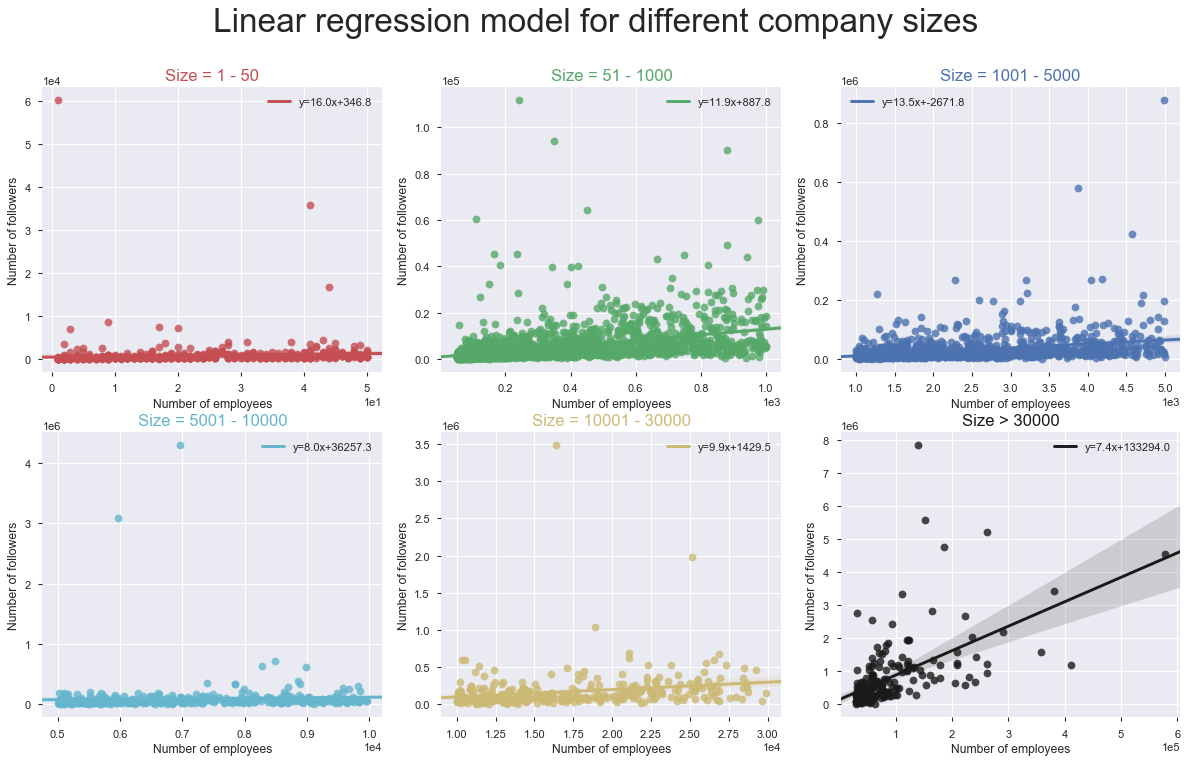

In [7]:
from sklearn.linear_model import LinearRegression

fig = plt.figure(figsize=(15, 10),  dpi= 80, facecolor='w', edgecolor='k')
st = fig.suptitle("Linear regression model for different company sizes", fontsize=30)

colors = ['r','g','b','c', 'y', 'k']
title = ['Size = 1 - 50','Size = 51 - 1000','Size = 1001 - 5000',
         'Size = 5001 - 10000','Size = 10001 - 30000', 'Size > 30000']

models = []
model = {}

for i in range(1,7): 
          
    linkd_bysize = linkd_unique[linkd_unique['size']==i]  
    X = linkd_bysize[['employees_on_platform','size']].values   
    y = linkd_bysize['followers_count'].values    
    
    model = LinearRegression()
    model.fit(X, y)

    models.append(model)  
    slope, intercept, r_value, p_value, std_err = stats.linregress(linkd_bysize['employees_on_platform'],
                                                               linkd_bysize['followers_count'])
    plt.subplot(2, 3, i)
    ax = sns.regplot(x='employees_on_platform', y='followers_count', data=linkd_bysize, color=colors[i-1], 
                     line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    ax.set(xlabel='Number of employees', ylabel='Number of followers')
    ax.legend()
    plt.title(title[i-1],fontsize="15", color=colors[i-1])
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
       
fig.tight_layout()

st.set_y(0.95)
fig.subplots_adjust(top=0.85)
plt.show()  

The percentage of outliers in different categories is very small

### Predicting number of followers

In [8]:
n_emp = 40000

conditions = [
    (n_emp > 0) & (n_emp <= 50),    
    (n_emp > 50) & (n_emp <= 1000),
    (n_emp > 1000) & (n_emp <= 5000),
    (n_emp > 5000) & (n_emp <= 10000),
    (n_emp > 10000) & (n_emp <= 30000),
    (n_emp > 30000)]
choices = [1, 2, 3, 4, 5, 6]
size_est  = np.select(conditions, choices, default=0)

X_predict = [[n_emp,size_est]]

y_predict = models[X_predict[0][1]-1].predict(X_predict)
print('If number of employees = ', n_emp, 'the predicted number of followers of the company is ', y_predict[0])     


If number of employees =  40000 the predicted number of followers of the company is  429391.52996024175


### Analyzing growth of company by year
Here I use the entire data of the companies to analyze its sucess with years. As an example I have shown top 15 companies in size > 30000 and size = 1001-5000. I have used the yearly growth as a test for the bigger picture. For a more granular study I will use growth per month in different years.

In [9]:
linkd_top = linkd_unique[linkd_unique['employees_on_platform'] > 30000]
top_comp = linkd_top['company_name'].unique()

linkd_mid = linkd_unique[(linkd_unique['employees_on_platform'] > 1000) 
                            & (linkd_unique['employees_on_platform'] <= 5000)]
mid_comp = linkd_mid['company_name'].unique()

Data for different companies in the two categories considered is grouped by year, and the ratio of number of followers and number of employees is calculated. This ratio is indicative of how hiring affects the growth.  

## Second Plot

In [10]:
datax=[]
for comp in top_comp[0:10]:
    dfc = linkd[linkd['company_name'] == comp]
    dfc['as_of_date'] = pd.to_datetime(dfc['as_of_date'])
    dfc['year'], dfc['month'], dfc['day'] = dfc['as_of_date'].dt.year, dfc['as_of_date'].dt.month, dfc['as_of_date'].dt.day
    dfc = dfc.sort_values(by=['year', 'month', 'day'])
    dfc1 = dfc    
    dfc1 = dfc1.groupby(['year'],as_index=False)['followers_count','employees_on_platform'].agg(np.ptp)
    dfc1['ratio'] = dfc1['followers_count']/ dfc1['employees_on_platform']
    
    
    tracex = go.Bar(x=dfc1['year'],y=dfc1['ratio'], name=comp)
    datax.append(tracex)
    
layout = go.Layout(barmode='stack',title = 'Ratio of followers and employees for large size companies',
                   xaxis=dict(title='YEAR',
        tickmode='linear',
        ticks='outside',
        tick0=0,
        dtick=1))
    
fig = go.Figure(data=datax, layout=layout)
py.iplot(fig)  

datax=[]
for comp in mid_comp[0:10]:
    dfc = linkd[linkd['company_name'] == comp]
    dfc['as_of_date'] = pd.to_datetime(dfc['as_of_date'])
    dfc['year'], dfc['month'], dfc['day'] = dfc['as_of_date'].dt.year, dfc['as_of_date'].dt.month, dfc['as_of_date'].dt.day
    dfc = dfc.sort_values(by=['year', 'month', 'day'])
    dfc1 = dfc    
    dfc1 = dfc1.groupby(['year'],as_index=False)['followers_count','employees_on_platform'].agg(np.ptp)
    dfc1['ratio'] = dfc1['followers_count']/ dfc1['employees_on_platform']
    #dfc1['ratio'] = dfc1['employees_on_platform']/ dfc1['followers_count']
    
    tracex = go.Bar(x=dfc1['year'],y=dfc1['ratio'], name=comp)
    datax.append(tracex)
    
layout = go.Layout(barmode='stack', title = 'Ratio of followers and employees for medium size companies',
                   xaxis=dict(title='YEAR',
        tickmode='linear',
        ticks='outside',
        tick0=0,
        dtick=1))
    
fig = go.Figure(data=datax, layout=layout)
py.iplot(fig)     

For biggest size companies, Microsoft has shown the most growth followed by Unilever and Facebook. For medium sized companies Netflix has shown a tremendous growth and is predicted to further grow in the coming years. This is followed by Twitter and Spotify. The next step is to make a decision-tree classifier to predict the growth of companies in future.

### Future steps
1. Scrape job postings, number of jobs filled and stock prices from LinkedIn, glassdoor and yahoo finance for concrete models.
2. Apply multilinear regression and decision-tree based machine learning algorthims for analysis. 
3. A sentiment analysis to find in demand skills of the top companies. 